# SuAVE Image to Label CNN Prediction Model

In [1]:
%%javascript
function getQueryStringValue (key)
{  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("survey_url='".concat(getQueryStringValue("surveyurl")).concat("'"));
IPython.notebook.kernel.execute("user='".concat(getQueryStringValue("user")).concat("'"));
IPython.notebook.kernel.execute("csv_file='".concat(getQueryStringValue("csv")).concat("'")); 
IPython.notebook.kernel.execute("dzc_file='".concat(getQueryStringValue("dzc")).concat("'")); 
IPython.notebook.kernel.execute("params='".concat(getQueryStringValue("params")).concat("'")); 
IPython.notebook.kernel.execute("active_object='".concat(getQueryStringValue("activeobject")).concat("'")); 

<IPython.core.display.Javascript object>

In [2]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import all packages (this might take a few seconds)

In [3]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras import backend as K

# More imports
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import csv
import pandas as pd
import re
import cv2
import os

# import the necessary packages for SVM predictor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import imutils
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

# Import widget functionality
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## This notebook uses the LeNet classifier model for prediction

In [4]:
class LeNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(64, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
		# third set of CONV => RELU => POOL layers
		model.add(Conv2D(256, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
              
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1000))
		model.add(Activation("relu"))
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

## Initializing the number of times the model will loop and its batch size for learning

In [5]:
epochCount = {
    '25 Iterations': 25,
    '50 Iterations': 50,
    '75 Iterations': 75
}

def f(epoch_count):
    return epoch_count

epochNum = interact(f, epoch_count=epochCount)

interactive(children=(Dropdown(description='epoch_count', options={'75 Iterations': 75, '25 Iterations': 25, '…

In [6]:
batchS = {
    '32 Batch Size': 32,
    '64 Batch Size': 64,
    '128 Batch Size': 128
}

def f(batch_size):
    return batch_size

batchNum = interact(f, batch_size=batchS)

interactive(children=(Dropdown(description='batch_size', options={'128 Batch Size': 128, '32 Batch Size': 32, …

In [7]:
# init the number of epochs to train for, init learning rate and batch size
EPOCHS = epochNum.widget.result
INIT_LR = 1e-3
BS = batchNum.widget.result

In [8]:
# init the image suffix, yset, and image list
suffix = '.jpg'
img_list = []
yset = []
# create labels list and 2 dicts for 2 way mapping
labels = []
# key = label value = number
label_yval = dict()
# key = number value = label
yval_label = dict()

In [9]:
# testing cell for Zeppelin Vanbarriger. Will be removed in production
survey_url = 'http://localhost:3001/main/file=Zeppelin-V-Alt_balthus_test.csv&views=1110000&view=grid'
params =''

# Testing Cells
csv_file = 'zaslavsk_Cyclops_Cave_Ceramic_Petrography.csv'


dzc_file = '/home/zep/WebstormProjects/SuAVE/app/public/imageserver/balthus/balthus.dzc'

dzc_url = 'http://localhost:3001/imageserver/balthus/balthus.dzc'

active_object = ''
actual_imageFolder = 'app/public/imagestore/balthus'
absolutePath = '/home/zep/WebstormProjects/SuAVE/app/public/imageserver/balthus/'

## Run and choose the column name that coresponds with the Image column in the CSV

In [10]:
# use csv file to grab images/labels
df = pd.read_csv(csv_file)

toImg = list(df.columns.values)

img_menu = {}
for i in range(0, len(toImg)):
    img_menu[toImg[i]] = toImg[i]

def f(images_menu):
    return images_menu
# choose which label is for images (commonly '#img')
out = interact(f, images_menu=img_menu)

FileNotFoundError: File b'zaslavsk_Cyclops_Cave_Ceramic_Petrography.csv' does not exist

## Run and choose the column name that coresponds with the column label to be predicted

In [14]:
# Choose column of label for prediction
toPredict = list(df.columns.values)

pred_menu = {}
for i in range(0, len(toPredict)):
    pred_menu[toPredict[i]] = toPredict[i]

def f(predictions_menu):
    return predictions_menu
# choose which label for predictions
out2 = interact(f, predictions_menu=pred_menu)

A Jupyter Widget

In [15]:
# grab chosen column names
nameCol = df[out.widget.result]
predCol = df[out2.widget.result]

# add all fabric columns to the y set
for i in range (0,len(predCol)):
    labels.append(predCol[i])

# grab all unique labels
uni_labels = set(labels)
uni_labels = list(uni_labels)

# assign each label a dict key number
for i in range(0,len(uni_labels)):
    yval_label[i] = uni_labels[i]
    label_yval[uni_labels[i]] = i
    
print("Number of labels to learn from: " + str(len(labels)))

Number of labels to learn from: 252


## Grab the images and configure them for predicting

### This might take a little while depending on the size of the dataset

In [16]:
# create list of keys associated with their labels
for i in range (0, len(labels)):
    yset.append(label_yval[labels[i]])
    
# gather images from path created from file names in csv file
for i in range (0,len(nameCol)):
    base_filename = nameCol[i]
    fileName = os.path.join("./Cyclops Cave/images/", base_filename + suffix)
    im = cv2.imread(fileName)
    im = cv2.resize(im, (28,28))
    im = img_to_array(im)
    img_list.append(im)

In [17]:
# Shuffle the data
p = np.random.permutation(len(yset))

# Relable for splitting sets
Y = []
X = []
for i in range(0,len(yset)):
    Y.append(yset[p[i]])
    X.append(img_list[p[i]])
    
# split the test and training set 75:25
split = int(len(X)*(.75))
xtrain = X[:split]
xtest = X[split:]
ytrain = Y[:split]
ytest = Y[split:]

# transform to arrays
trainX = np.array(xtrain, dtype="float")/225.0
testX = np.array(xtest, dtype ="float")/225.0

ytrain = np.array(ytrain)
ytest = np.array(ytest)

# parsed Y data containers
trainY = []
testY = []

# convert labels from int to vectors
trainY = np_utils.to_categorical(ytrain,12)
testY = np_utils.to_categorical(ytest,12)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True, fill_mode="nearest")

In [56]:
# initialize the model
model = LeNet.build(width=28, height=28, depth=3, classes=12)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

C:\Users\cinde\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\cinde\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\cinde\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


## Train the predictive model

### This is relative to the size of the data set and may take a few minutes 

In [58]:
# train the network
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

Epoch 1/25
6/5 [====================================] - 2s 369ms/step - loss: 1.0239 - acc: 0.6819 - val_loss: 1.3708 - val_acc: 0.6349
Epoch 2/25
6/5 [====================================] - 2s 338ms/step - loss: 1.0725 - acc: 0.6690 - val_loss: 1.2444 - val_acc: 0.6508
Epoch 3/25
6/5 [====================================] - 2s 338ms/step - loss: 1.0787 - acc: 0.6933 - val_loss: 1.3723 - val_acc: 0.6032
Epoch 4/25
6/5 [====================================] - 2s 340ms/step - loss: 1.0956 - acc: 0.6522 - val_loss: 1.3060 - val_acc: 0.6508
Epoch 5/25
6/5 [====================================] - 2s 338ms/step - loss: 1.0316 - acc: 0.6975 - val_loss: 1.3196 - val_acc: 0.6349
Epoch 6/25
6/5 [====================================] - 2s 335ms/step - loss: 1.0576 - acc: 0.6721 - val_loss: 1.2421 - val_acc: 0.6825
Epoch 7/25
6/5 [====================================] - 2s 340ms/step - loss: 0.9749 - acc: 0.6927 - val_loss: 1.2590 - val_acc: 0.6667
Epoch 8/25
6/5 [================================

## Plot the loss and accuracy

In [59]:
# plot the training loss and accuracy 
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Label Prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('figure.png')

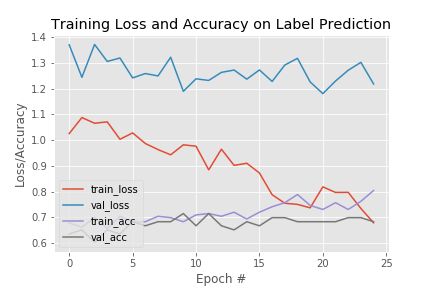

In [60]:
# Displays chart
from IPython.display import Image
Image("figure.png")

## Take the original data and predict based on the model

In [61]:
# Reshape original input data images for predicting
img_check = np.array(img_list, dtype ="float")/225.0

predictionsMade = []
preds = model.predict(img_check)

# Run all data through the prediction model that was created
for i in range (0,len(img_check)):
    predIndex = np.where(preds[i] == np.amax(preds[i]))
    prediction = int(predIndex[0][0])
    predictionsMade.append(prediction)
    
# Count how many correct predictions were made
correct = 0
for i in range (0,len(predictionsMade)):
    if(predictionsMade[i] == yset[i]):
        correct += 1 

## Calculate the accuracy of the predictions made

In [62]:
print("Accuracy: " + str(correct/len(yset)))

Accuracy: 0.8055555555555556


## Enter a new header for the prediction column

In [63]:
# Translate back to original csv label names
finalPred = []
for i in range (0,len(predictionsMade)):
    finalPred.append(yval_label[predictionsMade[i]])

from IPython.display import display
input_text = widgets.Text(
    value=None,
    placeholder='Type label here',
    disabled=False
)
output_text = widgets.Text(
    value=None,
    placeholder='New Header will be displayed here',
    disabled=False
)

def bind_input_to_output(sender):
    output_text.value = input_text.value

input_text.observe(bind_input_to_output)

print("Input new column Header Label: ")

display(input_text)
display(output_text)

Input new column Header Label: 


A Jupyter Widget

A Jupyter Widget

## Write the predictions back to the original CSV

In [64]:
# Append the new column w/ it's new column name
df[input_text.value] = finalPred

# new file name
new_file =  csv_file[:-4]+'_v1.csv'
df.to_csv(new_file, index=None)

In [65]:
#Input survey name

from IPython.display import display
input_text = widgets.Text()
output_text = widgets.Text()

def bind_input_to_output(sender):
    output_text.value = input_text.value

# Tell the text input widget to call bind_input_to_output() on submit
input_text.observe(bind_input_to_output)

print("Input survey name here:")
# Display input text box widget for input
display(input_text)

display(output_text)

Input survey name here:


A Jupyter Widget

A Jupyter Widget

In [66]:
import re
#Print survey name
survey_name = output_text.value
print("Survey name is:", survey_name)

Survey name is: Cyclops2


In [55]:
import requests
upload_url = "http://localhost:3001/uploadCSV"
upload_data = {'name': survey_name, 'dzc': dzc_url, 'user':user}
files = {"file": open(new_file, "rb")}
r = requests.post(upload_url, files=files, data=upload_data)
print(r.status_code, r.reason)

regex = re.compile('[^0-9a-zA-Z_]')
survey_url = survey_name
survey_url =  regex.sub('_', survey_url)

url = "http://localhost:3001/main/file=" + user + "_" + survey_url + ".csv" + "&views=111000&view=grid"
print(url)

ConnectionError: HTTPConnectionPool(host='localhost', port=3001): Max retries exceeded with url: /uploadCSV (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001C8E6B1D588>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it',))